In [1]:
!pip install modisco
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import gzip
from functools import partial
import ast
import dmslogo
import collections

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats

import Bio
from Bio import motifs
from Bio.motifs.matrix import PositionSpecificScoringMatrix
from operator import itemgetter
from modisco.visualization import viz_sequence

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

# from tqdm.auto import tqdm
# tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():
    @staticmethod
    def pad_pssm(row, pad_len=24, matrix_column='pssm', length_column='length'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row[length_column]] = row[matrix_column]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor

    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT,
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy()
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)

        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.55, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.8, colors=['green','blue','orange','red']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

def double_pad_seq_tensor(seq_tensor, pad_len=25):
    total_out_len = 2*pad_len + seq_tensor.shape[-1] - 2
    padded_tensor = torch.zeros((4, total_out_len))
    tensor_start = pad_len-1
    tensor_stop = tensor_start + seq_tensor.shape[-1]
    padded_tensor[..., tensor_start:tensor_stop] = seq_tensor
    return padded_tensor

def consecutiveRanges(a):
    n = len(a)
    length = 1
    list = []
    if (n == 0):
        return list
    for i in range (1, n + 1):
        if (i == n or a[i] -
            a[i - 1] != 1):
            if (length == 1):
                list.append([a[i - length]])
            else:
                temp = [a[i - length], a[i - 1]]
                list.append(temp)
            length = 1
        else:
            length += 1
    return list

In [4]:
def align_to_alphabet(in_tensor, in_alphabet=['A','C','G','T'], out_alphabet=constants.STANDARD_NT):
    permuted_idxs = []
    for nt in out_alphabet:
        permuted_idxs.append(in_alphabet.index(nt))
    permutation_idxs = torch.LongTensor(permuted_idxs)
    out_tensor = in_tensor[permutation_idxs, :]
    return out_tensor

def reverse_complement(in_tensor, alphabet=constants.STANDARD_NT):
    rc_dict = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
    reversed_alphabet = [rc_dict[nt] for nt in alphabet]
    out_tensor = align_to_alphabet(in_tensor, in_alphabet=alphabet,  out_alphabet=reversed_alphabet)
    out_tensor = torch.flip(out_tensor, dims=[1])
    return out_tensor

def show_streme_motifs(parsed_output, num_motifs=None):
    motif_dict = parsed_output['motif_results']
    results_alphabet = parsed_output['meta_data']['alphabet']
    if not num_motifs:
        Range = len(motif_dict)
    else:
        Range = num_motifs
    for motif_idx in range(Range):
        motif_ppm = torch.tensor((motif_dict[motif_idx]['ppm']))
        motif_ppm = align_to_alphabet(motif_ppm, in_alphabet=results_alphabet)
        motif_ppm_rc = reverse_complement(motif_ppm)
        print(motif_dict[motif_idx]['summary'])
        matrix_to_dms(ppm_to_IC(motif_ppm), y_max=2)
        plt.show()
        matrix_to_dms(ppm_to_IC(motif_ppm_rc), y_max=2)
        plt.show()

### TF motifs

In [5]:
file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCO_and_JASPAR_processed_TF_info.txt'

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)
tf_df['database'] = 'HOCOMOCO'

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

  0%|          | 0/9 [00:00<?, ?it/s]

### Sequence library

In [6]:
#----- BODA sequences -------
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v3.txt', sep=" ", low_memory=False)
no_controls_df = boda2_df[boda2_df['method'].notnull()].copy().reset_index(drop=True)

In [7]:
method = 'fsp'

data_df = no_controls_df[no_controls_df['method'] == method].reset_index(drop=True)

track_info = [a[1] for a in data_df['ID'].str.split('__').tolist() ]
data_df['penalty_track'] = track_info

quality_filter = (data_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
data_df = data_df[quality_filter].reset_index(drop=True)

tracks = list(set(zip(data_df['penalty_track'], data_df['target_cell'])))
tracks

[('346635', 'hepg2'),
 ('229779', 'hepg2'),
 ('619474', 'k562'),
 ('817810', 'sknsh'),
 ('730114', 'k562'),
 ('621411', 'sknsh'),
 ('477844', 'k562'),
 ('313665', 'hepg2'),
 ('893131', 'k562'),
 ('199840', 'sknsh'),
 ('969454', 'hepg2'),
 ('944763', 'hepg2'),
 ('323391', 'k562'),
 ('958155', 'sknsh'),
 ('942569', 'sknsh')]

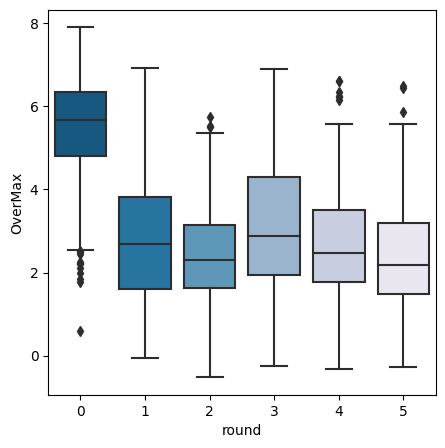

In [8]:
custom_palette = sns.color_palette("PuBu_r", 6)

temp_df = data_df[data_df['penalty_track'] == '893131'].reset_index(drop=True)
plt.figure(figsize=(5,5))
sns.boxplot(data=temp_df, x='round', y='OverMax', palette=custom_palette)
plt.ylabel('OverMax')
plt.show()

In [9]:
penalty_tracks = []
non_penalty_tracks = []
for track_id in data_df['penalty_track'].dropna().unique():
    example_df = data_df[(data_df['penalty_track'] == track_id)].reset_index()
    if example_df['round'].max() > 0:
        penalty_tracks.append(track_id)
    else:
        non_penalty_tracks.append(track_id)
penalty_tracks, non_penalty_tracks

(['313665',
  '969454',
  '346635',
  '944763',
  '477844',
  '730114',
  '619474',
  '893131',
  '199840',
  '958155',
  '621411',
  '817810'],
 ['229779', '323391', '942569'])

In [10]:
target_cells = ['k562', 'hepg2', 'sknsh']

streme_dicts = {'k562': {}, 'hepg2': {}, 'sknsh': {}}
out_streme_dicts = {'k562': {}, 'hepg2': {}, 'sknsh': {}}
for track in tracks:
    track_id, target_cell = track
    if track_id in penalty_tracks:
        streme_dicts[target_cell][track_id] = {}
        out_streme_dicts[target_cell][track_id] = {}
    else:
        continue

for root, dirs, files in os.walk('/content/drive/MyDrive/data/BODA2_MPRA/fsp_streme_dicts'):
    for file_path in files:
        _, method, cell_type, track_ID, random_tag, round = file_path.split('__')
        if random_tag in penalty_tracks:
            round_key = round.rstrip('.pt')
            streme_dicts[cell_type][random_tag][round_key] = torch.load(root + '/' + file_path)
        else:
            continue

##--- Sort the round keys
# for key_1 in streme_dicts.keys():
#     for key_2 in streme_dicts[key_1].keys():
#         d = streme_dicts[key_1][key_2]
#         streme_dicts[key_1][key_2] = collections.OrderedDict(sorted(d.items()))

#         d = out_streme_dicts[key_1][key_2]
#         out_streme_dicts[key_1][key_2] = collections.OrderedDict(sorted(d.items()))

In [12]:
for key_1 in streme_dicts.keys():
    print(f'--- {key_1} ---')
    for key_2 in streme_dicts[key_1].keys():
        print(key_2)
        #for key_3 in tqdm(streme_dicts[key_1][key_2].keys()):
        for key_3 in streme_dicts[key_1][key_2].keys():
            temp_dict = streme_dicts[key_1][key_2][key_3].copy()

            alphabet = temp_dict['meta_data']['alphabet']
            top_out_dict = temp_dict['motif_results'][0]
            ppm = top_out_dict['ppm']
            tag = top_out_dict['tag']

            pwm = ppm_to_pwm(torch.Tensor(ppm))
            pwm_rc = reverse_complement(pwm)
            pwm, pwm_rc = pwm.numpy(), pwm_rc.numpy()

            icm = ppm_to_IC(torch.Tensor(ppm))
            icm_rc = reverse_complement(icm)
            icm, icm_rc = icm.numpy(), icm_rc.numpy()

            value_lists = pwm.tolist()
            value_dict = {}
            for letter_idx, letter in enumerate(alphabet):
                value_dict[letter] = value_lists[letter_idx]

            bio_pssm = PositionSpecificScoringMatrix(alphabet=alphabet, values=value_dict)

            bio_pssm_rc = bio_pssm.reverse_complement()
            max_score = bio_pssm.max
            min_score = bio_pssm.min

            score_distribution = bio_pssm.distribution(precision = 10**4)
            threshold_patser = score_distribution.threshold_patser()
            threshold_fpr = score_distribution.threshold_fpr(0.0001)

            pssm = np.array([bio_pssm[x] for x in alphabet])
            pssm_rc = np.array([bio_pssm_rc[x] for x in alphabet])

            top_out_dict['pwm'] = pwm
            top_out_dict['icm'] = icm
            top_out_dict['pssm'] = pssm
            top_out_dict['pwm_rc'] = pwm
            top_out_dict['icm_rc'] = icm
            top_out_dict['pssm_rc'] = pssm_rc
            top_out_dict['max_score'] = max_score
            top_out_dict['min_score'] = min_score
            top_out_dict['threshold_patser'] = threshold_patser
            top_out_dict['threshold_fpr'] = threshold_fpr

            top_out_dict['target_cell'] = key_1
            top_out_dict['track_id'] = key_2
            top_out_dict['round'] = key_3

            top_out_dict['w'] = top_out_dict['summary']['w']
            top_out_dict['nsites'] = top_out_dict['summary']['nsites']
            top_out_dict['E'] = top_out_dict['summary']['E']

            out_streme_dicts[key_1][key_2][key_3] = top_out_dict.copy()

            #--- Save motif logos ---
            # matrix_to_dms(torch.tensor(icm), y_max=2, fontaspect=.55, widthscale=0.4,
            #         axisfontscale=0.6, heightscale=0.4)
            # plt.yticks([0,1,2])
            # plt.xlabel('')
            # plt.ylabel('Bits')
            # motif_name = f'{key_1}_{key_2}_{key_3}'
            # plt.title(motif_name, y=1.05, loc='left', fontsize=8)
            # save_path = '/content/drive/MyDrive/figures/penalized_motif_logos/' + motif_name + '.pdf'
            # plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
            # plt.show()

            # matrix_to_dms(torch.tensor(icm_rc), y_max=2, fontaspect=.55, widthscale=0.4,
            #                     axisfontscale=0.6, heightscale=0.4)
            # plt.yticks([0,1,2])
            # plt.xlabel('')
            # plt.ylabel('Bits')
            # motif_name = f'{key_1}_{key_2}_{key_3}_rc'
            # plt.title(motif_name, y=1.05, loc='left', fontsize=8)
            # save_path = '/content/drive/MyDrive/figures/penalized_motif_logos/' + motif_name + '.pdf'
            # plt.savefig(save_path, format='pdf', dpi=150, bbox_inches='tight', transparent=True)
            # plt.show()
        print('')

--- k562 ---
619474

730114

477844

893131

--- hepg2 ---
346635

313665

969454

944763

--- sknsh ---
817810

621411

199840

958155



In [13]:
all_dicts = []
for key_1 in out_streme_dicts.keys():
    for key_2 in out_streme_dicts[key_1].keys():
        for key_3 in out_streme_dicts[key_1][key_2].keys():
            all_dicts.append(out_streme_dicts[key_1][key_2][key_3])
            out_df = pd.DataFrame(all_dicts)

out_df['round'] = [int(x[1])-1 for x in out_df['round'].str.split('_').tolist()]
out_df = out_df.drop(['summary'], axis=1)

tf_max_length = out_df.w.max()
padding_fn = partial(utils.pad_pssm, matrix_column='pssm', length_column='w', pad_len=tf_max_length)
rc_padding_fn = partial(utils.pad_pssm, matrix_column='pssm_rc', length_column='w', pad_len=tf_max_length)
out_df['padded_pssm'] = out_df.apply(padding_fn, axis=1)
out_df['padded_pssm_rc'] = out_df.apply(rc_padding_fn, axis=1)

In [14]:
out_df

,tag,ppm,pwm,icm,pssm,pwm_rc,icm_rc,pssm_rc,max_score,min_score,threshold_patser,threshold_fpr,target_cell,track_id,round,w,nsites,E,padded_pssm,padded_pssm_rc
0,AGCTGTCAAM,"[[0.962847, 0.288861, 0.023704, 0.000203, 0.00...","[[1.9453784, 0.20844737, -3.3987257, -10.26623...","[[1.6709595, 0.1940548, 0.035858173, 0.0003053...","[[1.9453784227371216, 0.20844736695289612, -3....","[[1.9453784, 0.20844737, -3.3987257, -10.26623...","[[1.6709595, 0.1940548, 0.035858173, 0.0003053...","[[-2.2195253372192383, -4.388657569885254, -10...",17.407730,-81.611839,11.341731,9.604910,k562,619474,1,10,189,3.200000e-06,"[[1.9453784227371216, 0.20844736695289612, -3....","[[-2.2195253372192383, -4.388657569885254, -10..."
1,RCCACACCCMC,"[[0.35456, 0.053277, 0.007827, 0.85497, 0.0002...","[[0.50410163, -2.2303433, -4.997325, 1.7739457...","[[0.26567832, 0.083358034, 0.012075311, 1.1944...","[[0.5041016340255737, -2.2303433418273926, -4....","[[0.50410163, -2.2303433, -4.997325, 1.7739457...","[[0.26567832, 0.083358034, 0.012075311, 1.1944...","[[-1.5821491479873657, -2.0397374629974365, -9...",18.871552,-97.695824,12.874636,7.772118,k562,619474,4,11,149,3.200000e-05,"[[0.5041016340255737, -2.2303433418273926, -4....","[[-1.5821491479873657, -2.0397374629974365, -9..."
2,AGATAACCACA,"[[0.700914, 0.0002, 0.999403, 0.0002, 0.982836...","[[1.4873095, -10.287712, 1.9991385, -10.287712...","[[0.6071051, 0.0003983573, 1.9906206, 0.000398...","[[1.487309455871582, -10.287712097167969, 1.99...","[[1.4873095, -10.287712, 1.9991385, -10.287712...","[[0.6071051, 0.0003983573, 1.9906206, 0.000398...","[[-0.5430887937545776, -0.8879324793815613, -0...",18.148985,-80.276649,10.640831,10.124539,k562,619474,3,11,207,5.900000e-04,"[[1.487309455871582, -10.287712097167969, 1.99...","[[-0.5430887937545776, -0.8879324793815613, -0..."
3,AGATAAGGC,"[[0.690306, 0.00011, 0.999669, 0.00011, 0.9996...","[[1.465308, -11.150208, 1.9995224, -11.150208,...","[[0.7095728, 0.00021947028, 1.9945226, 0.00021...","[[1.4653079509735107, -11.150208473205566, 1.9...","[[1.465308, -11.150208, 1.9995224, -11.150208,...","[[0.7095728, 0.00021947028, 1.9945226, 0.00021...","[[-1.2241016626358032, -3.7083210945129395, -1...",16.137107,-90.425769,12.073464,8.110465,k562,619474,0,9,466,5.800000e-18,"[[1.4653079509735107, -11.150208473205566, 1.9...","[[-1.2241016626358032, -3.7083210945129395, -1..."
4,AWTTTGGCGCGMWAW,"[[0.511218, 0.371963, 0.116458, 0.000413, 0.00...","[[1.0320106, 0.573231, -1.1021184, -9.24157, -...","[[0.13805176, 0.13584946, 0.11621962, 0.000819...","[[1.032010555267334, 0.5732309818267822, -1.10...","[[1.0320106, 0.573231, -1.1021184, -9.24157, -...","[[0.13805176, 0.13584946, 0.11621962, 0.000819...","[[0.8947378396987915, -1.6145093441009521, 0.3...",22.820514,-95.234281,14.199308,7.043566,k562,619474,2,15,99,5.800000e-03,"[[1.032010555267334, 0.5732309818267822, -1.10...","[[0.8947378396987915, -1.6145093441009521, 0.3..."
5,TCGARGAWCH,"[[0.00027, 0.00027, 0.00027, 0.999184, 0.34635...","[[-9.8547535, -9.8547535, -9.8547535, 1.998822...","[[0.0005370728, 0.0005370827, 0.00029580604, 1...","[[-9.854753494262695, -9.854753494262695, -9.8...","[[-9.8547535, -9.8547535, -9.8547535, 1.998822...","[[0.0005370728, 0.0005370827, 0.00029580604, 1...","[[0.48213374614715576, -0.40519919991493225, 0...",15.674494,-77.074090,9.750582,10.893256,k562,730114,3,10,147,4.800000e-05,"[[-9.854753494262695, -9.854753494262695, -9.8...","[[0.48213374614715576, -0.40519919991493225, 0..."
6,ACAGCTGTCAAV,"[[0.630327, 0.027803, 0.966934, 0.056599, 0.00...","[[1.3341724, -3.1686156, 1.9514893, -2.1430798...","[[0.37807214, 0.030297168, 1.7176588, 0.071633...","[[1.3341723680496216, -3.1686155796051025, 1.9...","[[1.3341724, -3.1686156, 1.9514893, -2.1430798...","[[0.37807214, 0.030297168, 1.7176588, 0.071633...","[[-2.4564051628112793, -4.0362772941589355, -5...",21.134699,-95.131275,14.457101,6.750540,k562,730114,0,12,439,4.100000e-17,"[[1.3341723680496216, -3.1686155796051025, 1.9...",

In [15]:
all_plot_dfs = []
for cell_type in out_streme_dicts.keys():
    print(f'-------------- {cell_type} --------------')
    print('')
    for penalty_track in out_streme_dicts[cell_type].keys():
        print(f'{penalty_track}')
        track_motif_df = out_df[out_df['track_id'] == penalty_track].sort_values('round').reset_index(drop=True)

        #---
        track_score_thresholds = torch.Tensor(np.stack(2*track_motif_df['threshold_patser'].tolist()))
        track_max_scores = torch.Tensor(np.stack(2*track_motif_df['max_score'].tolist()))

        track_pssms = torch.Tensor(np.stack(track_motif_df['padded_pssm'].tolist()))
        track_pssms_rc = torch.Tensor(np.stack(track_motif_df['padded_pssm_rc'].tolist()))

        track_filters = torch.cat([track_pssms, track_pssms_rc])

        #---
        track_sequences_df = data_df[data_df['penalty_track'] == penalty_track].reset_index(drop=True)
        track_sequences_df = track_sequences_df.sort_values(by=['round', 'OverMax'], na_position='first').reset_index(drop=True)

        quality_filter = (track_sequences_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)
        track_sequences_df = track_sequences_df[quality_filter].reset_index(drop=True)

        #---
        track_onehot_sequences = torch.stack([double_pad_seq_tensor(utils.dna2tensor(seq), pad_len=track_filters.shape[-1]) \
                                                    for seq in track_sequences_df['sequence'].tolist()]).type(torch.float32)
        track_scores = F.conv1d(track_onehot_sequences, track_filters)

        #---
        scores_above = track_scores * (track_scores > track_score_thresholds[None, :, None])
        scores_above = scores_above / track_max_scores[None, :, None]
        scores_above = scores_above.sum(dim=-1)
        scores_above = scores_above[:, 0:len(track_motif_df)] + scores_above[:, len(track_motif_df):]
        scores_above[scores_above == 0.0] = np.nan

        # scores_above = track_scores.max(dim=-1)[0]
        # scores_above = scores_above / track_max_scores[None, :]
        # scores_above = torch.max(scores_above[:, 0:len(track_motif_df)], scores_above[:, len(track_motif_df):])

        # temp_maxs = torch.max(track_scores, dim=-1)[0]
        # temp_maxs = torch.stack([temp_maxs[:, 0:len(track_motif_df)], temp_maxs[:, len(track_motif_df):]])
        # scores_above = temp_maxs.max(dim=0)[0]

        #---
        motif_scores_columns = [f'Motif {i+1}' for i in range(scores_above.shape[-1])]
        track_sequences_df[motif_scores_columns] = scores_above.numpy()

        #---
        plot_df = track_sequences_df[motif_scores_columns].stack(dropna=False).reset_index()
        stack_round_list = []
        for x in track_sequences_df['round'].tolist():
            for i in range(5):
                stack_round_list.append(x)
        plot_df['Round'] = stack_round_list

        stack_overmax_list = []
        for x in track_sequences_df['OverMax'].tolist():
            for i in range(5):
                stack_overmax_list.append(x)
        plot_df['OverMax'] = stack_overmax_list

        all_plot_dfs.append(plot_df)

        # with plt.style.context('fivethirtyeight'):
        #     mpl.rcParams['lines.linewidth'] = 1.0
        #     sns.catplot(data=plot_df, x='round', y=0, hue='level_1', kind="boxen",
        #                 showfliers=False, hue_order=motif_scores_columns, order=range(6),
        #             aspect=4)
        #     plt.ylabel('motif score')
        #     #plt.ylim(0,4)
        #     plt.show()


        #     sns.catplot(data=plot_df, x='level_1', y=0, hue='round', kind="boxen",
        #                 showfliers=False, order=motif_scores_columns, hue_order=range(6),
        #             aspect=4)
        #     plt.xlabel('')
        #     plt.ylabel('motif score')
        #     #plt.ylim(0,4)
        #     plt.show()

        #     print('')

-------------- k562 --------------

619474
730114
477844
893131
-------------- hepg2 --------------

346635
313665
969454
944763
-------------- sknsh --------------

817810
621411
199840
958155


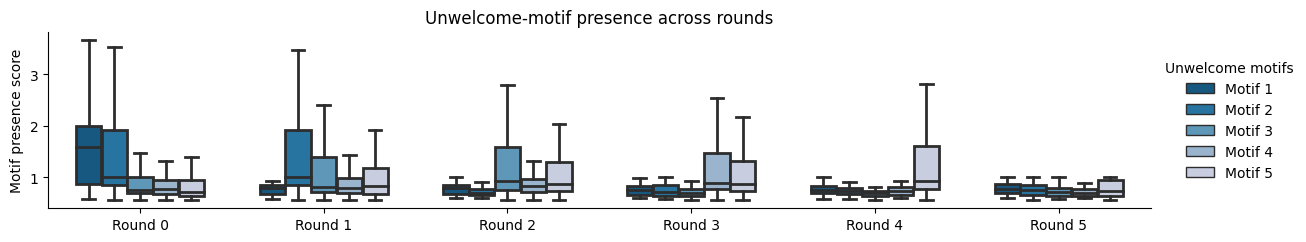

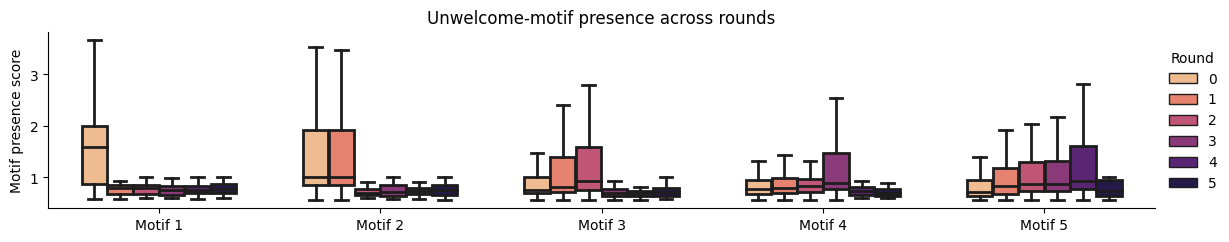

In [16]:
big_plot_df = pd.concat(all_plot_dfs)
big_plot_df = big_plot_df.rename({'level_1': 'Unwelcome motifs'}, axis=1)

aspect = 4.7
height = 2.5
width = 0.7
linewidth = 2
#with plt.style.context('fivethirtyeight'):
with plt.style.context('fast'):
    custom_palette = sns.color_palette("PuBu_r", 6)

    mpl.rcParams['lines.linewidth'] = linewidth
    sns.catplot(data=big_plot_df, x='Round', y=0, hue='Unwelcome motifs', kind="box",
                showfliers=False, hue_order=motif_scores_columns, order=range(6),
                palette=custom_palette, aspect=aspect, width=width, height=height)
    plt.xlabel('')
    plt.xticks(list(range(6)), labels=[f'Round {i}' for i in range(6)])
    plt.ylabel('Motif presence score', fontsize=10)
    plt.title('Unwelcome-motif presence across rounds')
    #plt.ylim(-0.1, 4)
    plt.savefig(f"/content/drive/MyDrive/figures/penalized_motif_presence_T.pdf", bbox_inches = 'tight', pad_inches=0, dpi=200)
    plt.show()

    custom_palette = sns.color_palette("magma_r", 6) #sns.color_palette("PuBu_r", 8)

    sns.catplot(data=big_plot_df, x='Unwelcome motifs', y=0, hue='Round', kind="box",
                showfliers=False, order=motif_scores_columns, hue_order=range(6),
                palette=custom_palette, aspect=aspect, width=width, height=height)
    plt.xlabel('')
    plt.ylabel('Motif presence score', fontsize=10)
    plt.title('Unwelcome-motif presence across rounds')
    #plt.ylim(-0.1, 4)
    plt.savefig(f"/content/drive/MyDrive/figures/penalized_motif_presence.pdf", bbox_inches='tight', pad_inches=0, dpi=200)
    plt.show()

In [ ]:
quality_filter = (no_controls_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= 1.0)

#--- GS
gs_df = no_controls_df[quality_filter & (no_controls_df['method'] == 'gs')].reset_index(drop=True)

gs_df = gs_df[['method', 'OverMax']]
gs_df = gs_df.rename({'method': 'Round'}, axis=1)

#---DHS
dhs_df = no_controls_df[quality_filter & (no_controls_df['method'] == 'DHS')].reset_index(drop=True)

dhs_df = dhs_df[['method', 'OverMax']]
dhs_df = dhs_df.rename({'method': 'Round'}, axis=1)

gs_dhs_penal_df = pd.concat([big_plot_df[['Round', 'OverMax']], gs_df, dhs_df])

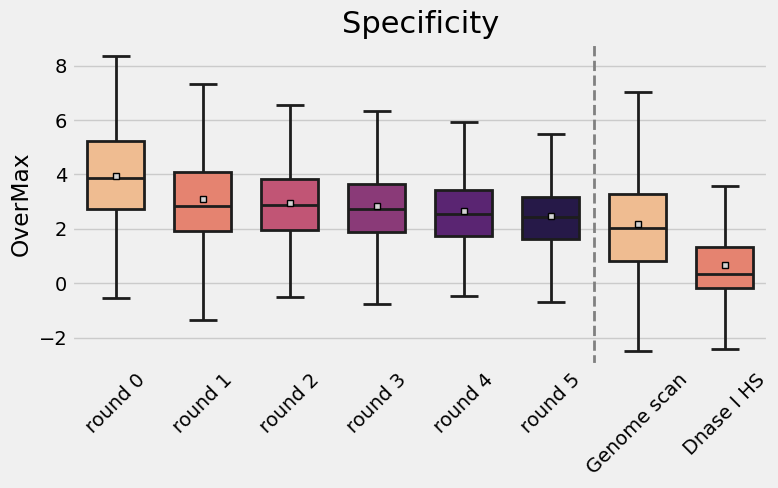

In [ ]:
with plt.style.context('fivethirtyeight'):
    mpl.rcParams['lines.linewidth'] = linewidth
    plt.figure(figsize=(8, 4))
    g = sns.boxplot(data=gs_dhs_penal_df, x='Round', y='OverMax', showfliers=False, palette=custom_palette, width=0.65,
                   showmeans=True, meanprops={"marker":"s", "markerfacecolor":"lightgrey", "markeredgecolor":"black", 'markersize':5})
    g.axvline(x=5.5, ymin=0, ymax=2, linewidth=2, color='grey', linestyle='--')
    plt.title('Specificity', fontsize=22)
    plt.xlabel('')
    xticklabels = [f'round {i}' for i in range(6)] + ['Genome scan', 'Dnase I HS']
    g.set_xticklabels(xticklabels, rotation=45)
    plt.show()

In [52]:
out_df = out_df.drop(columns=['padded_pssm', 'padded_pssm_rc'])
out_df.to_csv('/content/drive/MyDrive/data/BODA2_MPRA/all_fsp_streme_table.txt', sep='\t', index=None)